In [31]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import textwrap
from datetime import datetime

## Recent AK COVID-19 data
- https://coronavirus-response-alaska-dhss.hub.arcgis.com/datasets/table-3-demographic-distribution-of-confirmed-cases/geoservice

In [32]:
query_url = ("https://services1.arcgis.com/"
             "WzFsmainVTuD5KML/arcgis/rest/services/"
             "Demographic_Distribution_of_Confirmed_Cases/"
             "FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json")

retrieval_date = datetime.now()

In [33]:
r = requests.get(query_url)
case_data = pd.json_normalize(r.json(), record_path='features')

case_data.columns = case_data.columns.str.lstrip('attributes.')
case_data.columns = case_data.columns.str.replace('_',' ')
# case_data.columns = case_data.columns.str.lower()
case_data = case_data.drop(columns=['ObjectId'])
case_data = case_data.set_index('Demographic')
case_data.index.name = None

# convert percentage strings to floats
percent_columns = case_data.filter(regex='Percentage').columns
for percent_column in percent_columns:
    case_data[percent_column] = case_data[percent_column].str.rstrip('%').astype('float')

    
# rename columns
case_data = case_data.rename(
    index={
        'AI/AN':'Alaska Native or American Indian',
        'NHOPI':'Native Hawaiian or Other Pacific Islander',
        'Black':'Black or African American',
        'Multiple': 'Multiple Races',
        'Other': 'Other Race',
        'UI Race': 'Race Under Investigation',
        'Hispanic': 'Hispanic or Latino',
        'Non-Hispanic': 'Non-Hispanic Ethnicity',
        'UI Ethnicity': 'Ethnicity Under Investigation',
    })

## Race and ethnicity population data from US Census
- https://data.census.gov/cedsci/table?q=race&g=0400000US02&d=ACS%201-Year%20Estimates%20Detailed%20Tables&tid=ACSDT1Y2019.C02003&hidePreview=true

In [270]:
ethnicity_pop_est = pd.read_csv('../resources/ACSDT1Y2019.B03002-2021-01-16T204950.csv',
                      thousands=',', index_col="Label")
ethnicity_pop_est.index = ethnicity_pop_est.index.str.lstrip()
ethnicity_pop_est = ethnicity_pop_est.rename(
    index={
        'Hispanic or Latino:': 'Hispanic or Latino'
    })
ethnicity_pop_est = ethnicity_pop_est.rename(
    columns={
        'Alaska!!Estimate': 'Population Estimate',
        'Alaska!!Margin of Error': 'Error Margin',
    })
ethnicity_pop_est = ethnicity_pop_est.drop(columns=['Error Margin'])

In [189]:
race_pop_est = pd.read_csv('../resources/ACSDT1Y2019.C02003-2021-01-16T203459.csv',
                      thousands=',', index_col="Label")
race_pop_est.index = race_pop_est.index.str.lstrip()
race_pop_est = race_pop_est.rename(
    index={
        'Population of two or more races:': 'Multiple Races',
        'Some other race': 'Other Race',
    })
race_pop_est = race_pop_est.rename(
    columns={
        'Alaska!!Estimate': 'Population Estimate',
        'Alaska!!Margin of Error': 'Error Margin',
    })
race_pop_est = race_pop_est.drop(columns=['Error Margin'])
race_pop_est.index.name = None

In [241]:
race_pop_est

,Population Estimate
Total:,731545
Population of one race:,674069
White,469771
Black or African American,22551
American Indian and Alaska Native,115544
Asian,43678
Native Hawaiian and Other Pacific Islander,9923
Other Race,12602
Multiple Races,57476
Two races including Some other race,2591


## Race and ethnicity population data from AKDLWD
>"These data were developed through a combination of estimates from the Alaska Department of Labor and Workforce Development, and the U.S. Census Bureau. Sources: Alaska Department of Labor and Workforce Development, Research and Analysis Section; and U.S. Census Bureau"
> ([source](https://live.laborstats.alaska.gov/pop/))

Note: this source does not have "Other Race" as a category. Both the case data and the US Census data do have that category, and the US Census reports that 12602 people reported themselves as "Other Race" in 2019.

In [44]:
race_pop_est = pd.read_excel('../resources/RaceHispAK.xls', header=3)
race_pop_est = race_pop_est.set_index("Unnamed: 0")
race_pop_est.index.name = ''
race_pop_est = race_pop_est.dropna(how="all")
race_pop_est = race_pop_est.drop(columns=["Unnamed: 1"])

race_pop_est = race_pop_est.rename(index= {
    'White (alone)':'White',
    'Alaska Native or American Indian (alone)':'Alaska Native or American Indian',
    'Black or African American (alone)':'Black or African American',
    'Asian (alone)':'Asian',
    'Native Hawaiian or Other Pacific Islander (alone)':'Native Hawaiian or Other Pacific Islander',
    'Two or More Races':'Multiple Races',
    'Hispanic Origin (of any race)':'Hispanic or Latino'
})
race_pop_est = race_pop_est[['July 2019']]
race_pop_est = race_pop_est.rename(columns={'July 2019':'Population Estimate'})

In [45]:
race_pop_est

,Population Estimate
,
Total,731007.0
White,477041.0
Alaska Native or American Indian,113714.0
Black or African American,26895.0
Asian,47916.0
Native Hawaiian or Other Pacific Islander,10603.0
Multiple Races,54838.0
Total Responses*,791515.0
White (alone or in combination),525888.0


In [54]:
include_race_list = [
    'Alaska Native or American Indian',
    'Asian',
    'Black or African American',
    'Native Hawaiian or Other Pacific Islander',
    'White',
    'Hispanic or Latino',
    'Multiple Races'
]


other_includes = [
    'Unknown Race',
    'Race Under Investigation'
]

plot_order = [
    'American Indian and Alaska Native',
    'Asian',
    'Black or African American',
    'Hispanic or Latino',
    'Native Hawaiian and Other Pacific Islander',
    'White',
#     'Other Race',
    'Multiple Races'
]

In [56]:
race_pop_data = case_data.loc[include_race_list+other_includes]
race_pop_data = race_pop_data.join(race_pop_est.loc[include_race_list])

In [57]:
race_pop_data

,All Cases,All Cases Percentage,Community Cases,Community Cases Percentage,Secondary Cases,Secondary Cases Percentage,Travel Cases,Travel Cases Percentage,UI Cases,UI Cases Percentage,Hospitalizations,Hospitalizations Percentage,Deaths,Deaths Percentage,Population Estimate
Alaska Native or American Indian,10841,21.4,439,27.1,502,24.7,51,12.3,9742,21.2,309,27.0,95,37.8,113714.0
Asian,2026,4.0,79,4.9,101,5.0,19,4.6,1805,3.9,110,9.6,27,10.8,47916.0
Black or African American,1290,2.5,93,5.7,116,5.7,21,5.1,1046,2.3,45,3.9,9,3.6,26895.0
Native Hawaiian or Other Pacific Islander,1398,2.8,76,4.7,139,6.8,4,1.0,1174,2.6,120,10.5,16,6.4,10603.0
White,15843,31.2,723,44.6,863,42.5,253,61.3,13829,30.1,376,32.8,99,39.4,477041.0
Hispanic or Latino,2745,5.4,123,7.6,181,8.9,44,10.7,2371,5.2,58,5.1,11,4.4,52842.0
Multiple Races,3987,7.9,74,4.6,93,4.6,13,3.1,3777,8.2,69,6.0,2,0.8,54838.0
Unknown Race,497,1.0,94,5.8,163,8.0,36,8.7,0,0.0,9,0.8,1,0.4,NaN
Race Under Investigation,8470,16.7,0,0.0,0,0.0,0,0.0,8470,18.4,62,5.4,2,0.8,NaN


In [37]:
race_pop_data = case_data.loc[include_race_list+other_includes]
race_pop_data = race_pop_data.join(race_pop_est.loc[include_race_list])

eth_pop_data = case_data.loc[include_ethnicity_list]
eth_pop_data = eth_pop_data.join(ethnicity_pop_est.loc[include_ethnicity_list])

race_pop_data = race_pop_data.append(eth_pop_data)
race_pop_data = race_pop_data.reindex(plot_order+other_includes)

NameError: name 'ethnicity_pop_est' is not defined

In [58]:
race_pop_data[['All Cases', 'Hospitalizations', 'Deaths', 'Population Estimate']]

,All Cases,Hospitalizations,Deaths,Population Estimate
Alaska Native or American Indian,10841,309,95,113714.0
Asian,2026,110,27,47916.0
Black or African American,1290,45,9,26895.0
Native Hawaiian or Other Pacific Islander,1398,120,16,10603.0
White,15843,376,99,477041.0
Hispanic or Latino,2745,58,11,52842.0
Multiple Races,3987,69,2,54838.0
Unknown Race,497,9,1,NaN
Race Under Investigation,8470,62,2,NaN


In [70]:
rate_data = race_pop_data[['All Cases', 'Hospitalizations', 'Deaths']].div(race_pop_data['Population Estimate'], axis=0)

rate_data = rate_data.rename(columns={
    "All Cases": "Case Rate",
    "Hospitalizations": "Hospitalization Rate",
    "Deaths": "Death Rate"
})

In [62]:
rate_data

,Case Rate,Hospitalization Rate,Death Rate
Alaska Native or American Indian,0.095336,0.002717,0.000835
Asian,0.042282,0.002296,0.000563
Black or African American,0.047964,0.001673,0.000335
Native Hawaiian or Other Pacific Islander,0.131849,0.011318,0.001509
White,0.033211,0.000788,0.000208
Hispanic or Latino,0.051947,0.001098,0.000208
Multiple Races,0.072705,0.001258,0.000036


In [63]:
def save_png(figure, png_path):
    
    print(f'Saving PNG {png_path}')
    figure.savefig(png_path, bbox_inches='tight', pad_inches=0.3, dpi=72, facecolor='w')
    plt.close(figure) # comment out if you want outputs on the screen

## Infection, hospitalization, and deaths for each population

In [64]:
def count_plot(
    _series,
    color = '#006B95',
    title = '',
    width = 0.9
):
    """Plot a series as a vertical bar chart."""
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    
    x_labels = _series.index
    x_locs = np.arange(len(x_labels))  # the label locations    
    y_values = _series.values
    rects1 = ax.bar(x_locs, y_values, width, color=color)

    ax.set_xticks(np.arange(len(x_locs)))
    x_labels = ['\n'.join(textwrap.wrap(label, 13)) for label in x_labels]
    ax.set_xticklabels(x_labels, rotation=0, fontweight='normal', fontsize=10)
    ax.set_ylabel('Total Count', fontsize=16, labelpad=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='x', labelsize=16, length=0)
    ax.tick_params(axis='x', pad=10)    
    ax.tick_params(axis='y', labelsize=16, length=10)
    ax.set_title(title, fontsize=36, fontweight='bold', loc='left', pad=25)
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:0.0f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 20),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='top',
                        fontsize=18, fontweight='bold', color='#000000')
    autolabel(rects1)
    
    plt.figtext(0.0, -0.14, "Sources:", ha="left", va='top', fontsize=16, fontweight='bold', linespacing=1.5, color='#555555')
    sources_text = (
        f"COVID-19 case counts from AK DHSS: coronavirus-response-alaska-dhss.hub.arcgis.com. "
    )
    plt.figtext(0.056, -0.14, sources_text, ha="left", va='top', fontsize=16, linespacing=1.5, color='#555555')
    plt.figtext(0.0, -0.165, "Notes:", ha="left", va='top', fontsize=16, fontweight='bold', linespacing=1.5, color='#555555')
    notes_text = (
        f'Hispanic or Latino ethnicity is not mutually exclusive of race. '
        f"Data retrieved on {retrieval_date.strftime('%b %d, %Y at %-I:%M %p')}"
    )
    plt.figtext(0.044, -0.165, notes_text, ha="left", va='top', fontsize=16, linespacing=1.5, color='#555555')

    return fig

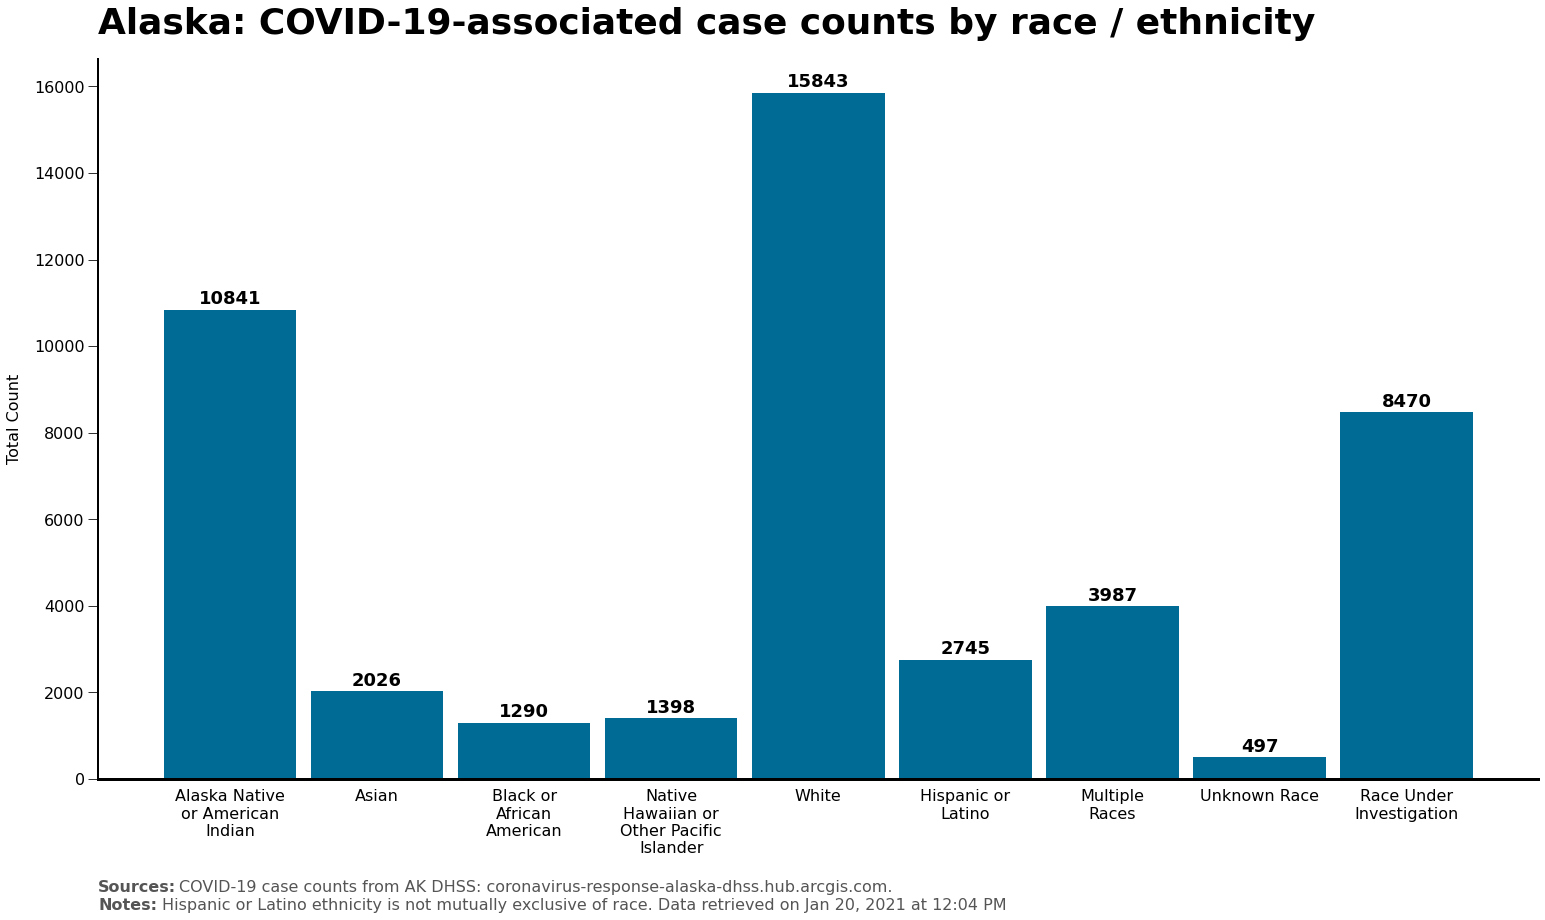

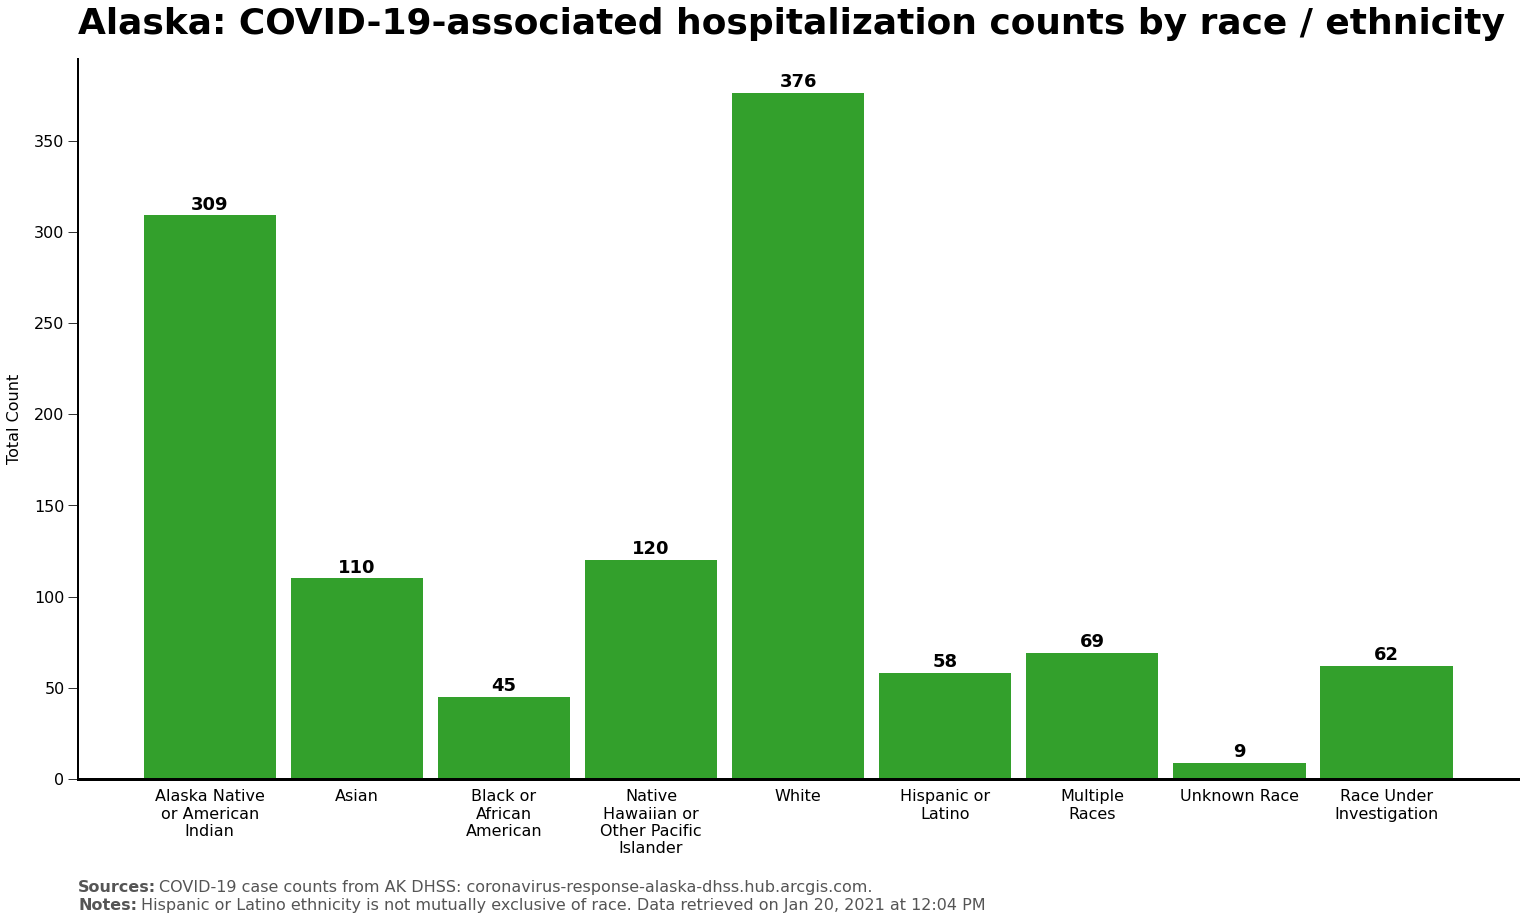

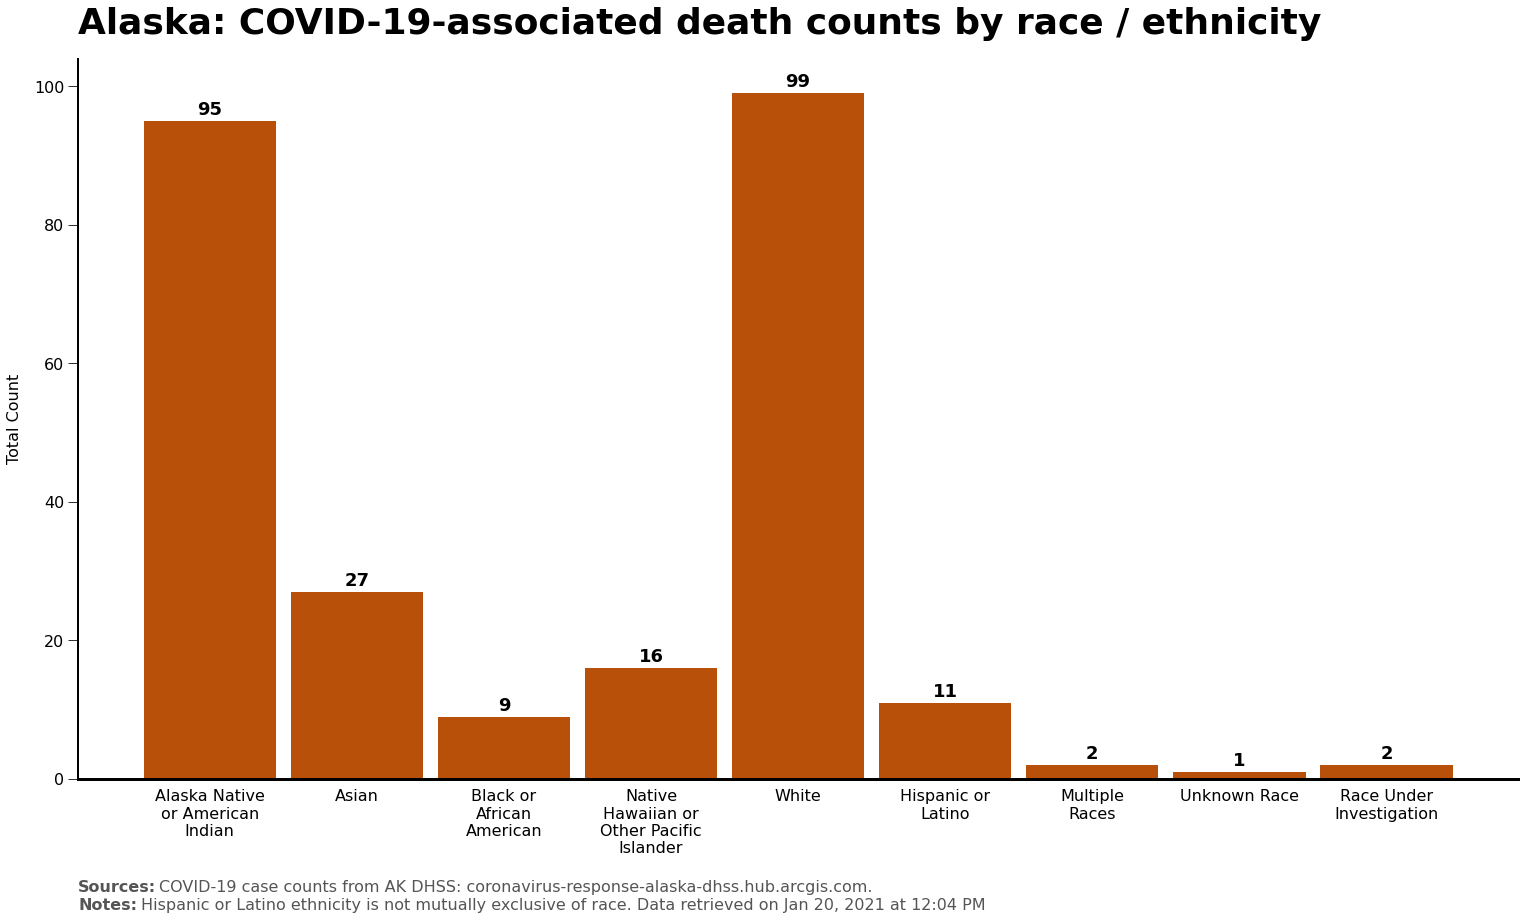

In [65]:
case_count_plot = count_plot(race_pop_data['All Cases'], title='Alaska: COVID-19-associated case counts by race / ethnicity')
hosp_count_plot = count_plot(race_pop_data['Hospitalizations'], title='Alaska: COVID-19-associated hospitalization counts by race / ethnicity', color='#33a02c')
deat_count_plot = count_plot(race_pop_data['Deaths'], title='Alaska: COVID-19-associated death counts by race / ethnicity', color='#B85009')

In [66]:
save_png(case_count_plot, f"../outputs/archived/{retrieval_date.strftime('%Y%m%d')}-case-count-by-race.png")
save_png(hosp_count_plot, f"../outputs/archived/{retrieval_date.strftime('%Y%m%d')}-hospitalization-count-by-race.png")
save_png(deat_count_plot, f"../outputs/archived/{retrieval_date.strftime('%Y%m%d')}-death-count-by-race.png")

Saving PNG ../outputs/archived/20210120-case-count-by-race.png
Saving PNG ../outputs/archived/20210120-hospitalization-count-by-race.png
Saving PNG ../outputs/archived/20210120-death-count-by-race.png


In [75]:
def rate_plot(
    _series,
    color = '#006B95',
    title = '',
    width = 0.9
):
    
    # categories
    x_labels = _series.index
    x_labels = ['\n'.join(textwrap.wrap(label, 18)) for label in x_labels]
    x_locs = np.arange(len(x_labels))  # the label locations    
    # y-values
    y_values = _series.values * 100000
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    
    rects1 = ax.bar(x_locs, y_values, width, color=color)

#    xlabels = [re.sub("(.{10})", "\\1\n", label, 0, re.DOTALL) for label in xlabels]
    ax.set_xticks(np.arange(len(x_locs)))
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_ylabel('Rate per 100,000 population', fontsize=16, labelpad=12)
    # grid
#     ax.grid(axis='y')
#     ax.set_axisbelow(True)
#     ax.yaxis.grid(color='lightgray', linestyle='dashed')

    # Hide stuff
#     ax.yaxis.label.set_visible(False)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(2)

    # Tick size
    ax.tick_params(axis='x', labelsize=16, length=0)
    ax.tick_params(axis='x', pad=10)
    
    ax.tick_params(axis='y', labelsize=16, length=10)

    ax.set_title(title, fontsize=30, fontweight='bold', loc='left', pad=25)
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:0.0f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 20),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='top',
                        fontsize=18,
                        fontweight='bold',
                        color='#000000'
                       )
    autolabel(rects1)
    

    
    plt.figtext(0.0, -0.11, "Sources:", ha="left", va='top', fontsize=16, fontweight='bold', linespacing=1.5, color='#555555')
    sources_text = (
        f"(1) COVID-19 case counts from AK DHSS: coronavirus-response-alaska-dhss.hub.arcgis.com. "
        f"(2) Population estimates from July 2019: live.laborstats.alaska.gov/pop/\n"
    )
    plt.figtext(0.056, -0.11, sources_text, ha="left", va='top', fontsize=16, linespacing=1.5, color='#555555')
    plt.figtext(0.0, -0.14, "Notes:", ha="left", va='top', fontsize=16, fontweight='bold', linespacing=1.5, color='#555555')
    notes_text = (
        f'"Unknown Race" or "Race Under Investigation" are not included. '
        f'Hispanic or Latino ethnicity is not mutually exclusive of race. '
        f"Data retrieved on {retrieval_date.strftime('%b %d, %Y at %-I:%M %p')}"
    )
    plt.figtext(0.044, -0.14, notes_text, ha="left", va='top', fontsize=16, linespacing=1.5, color='#555555')

    
    return fig

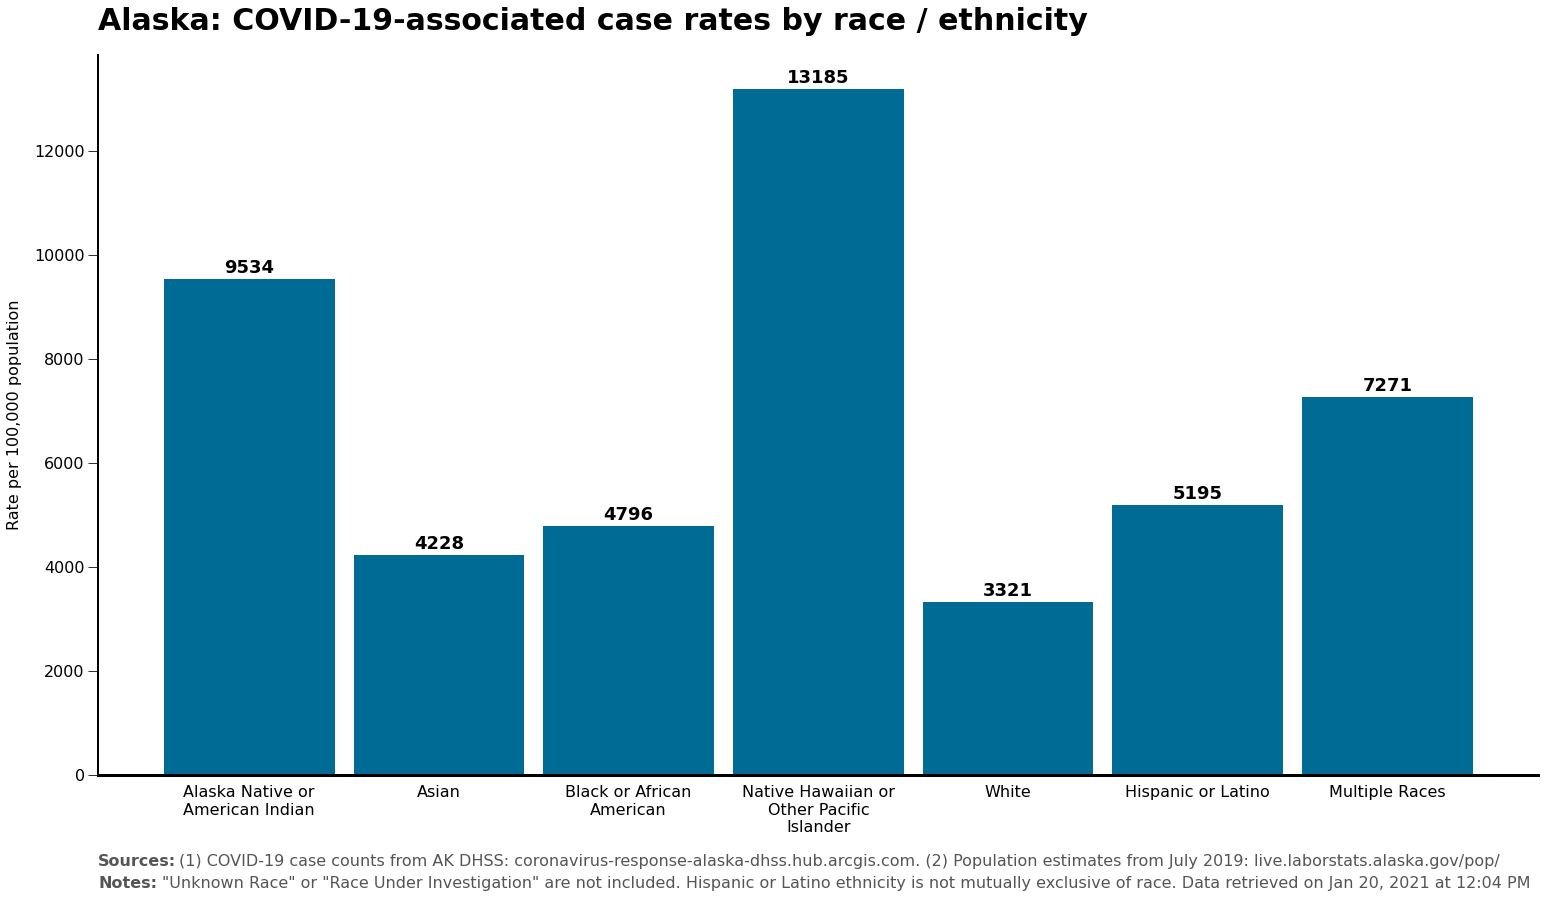

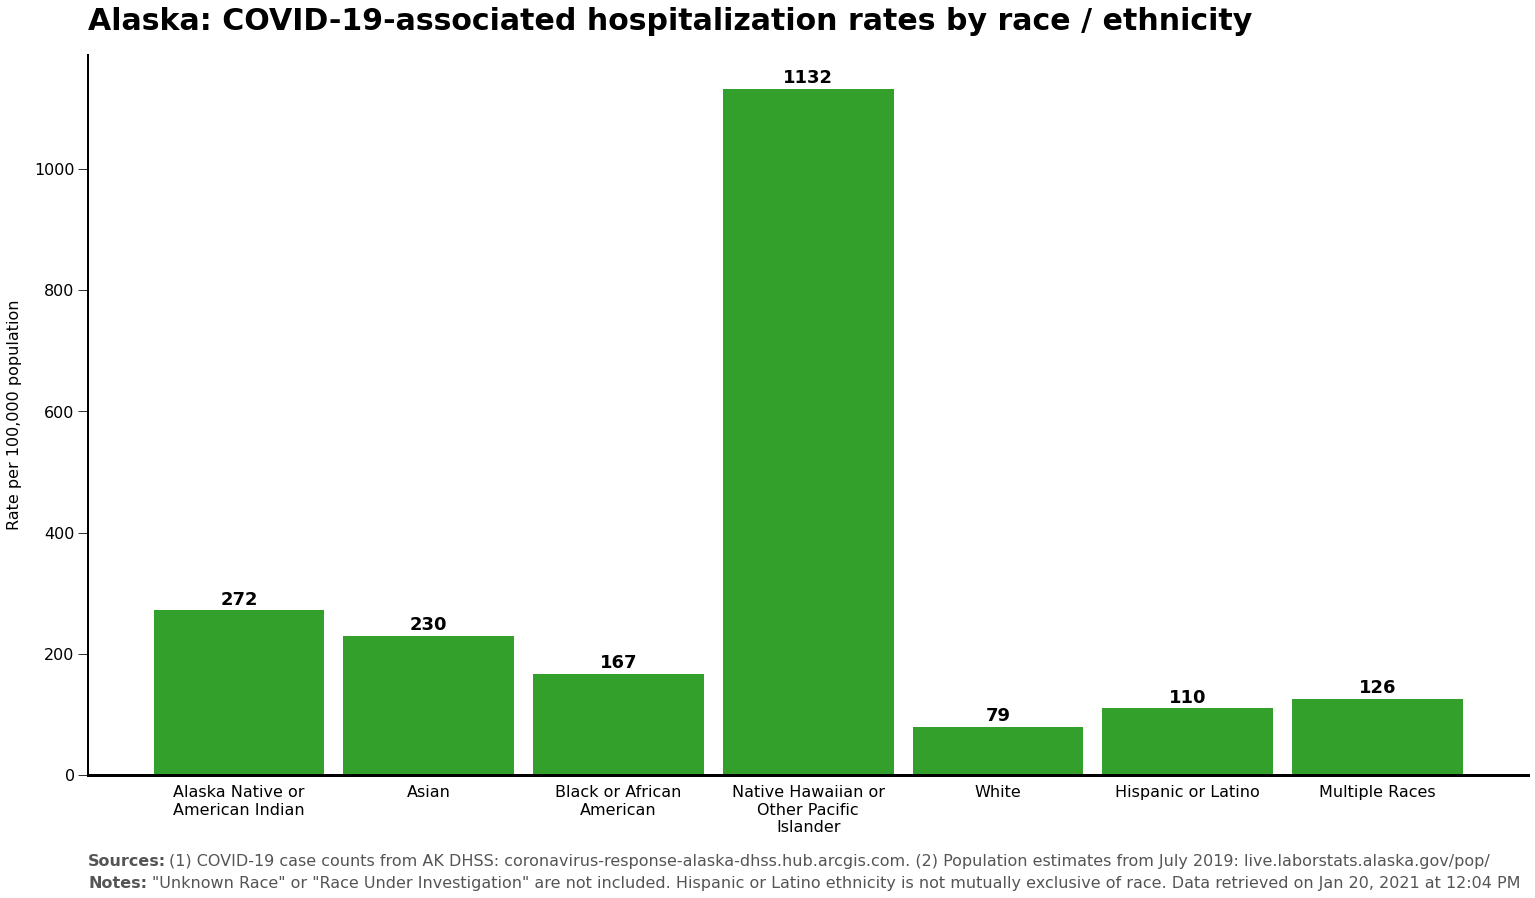

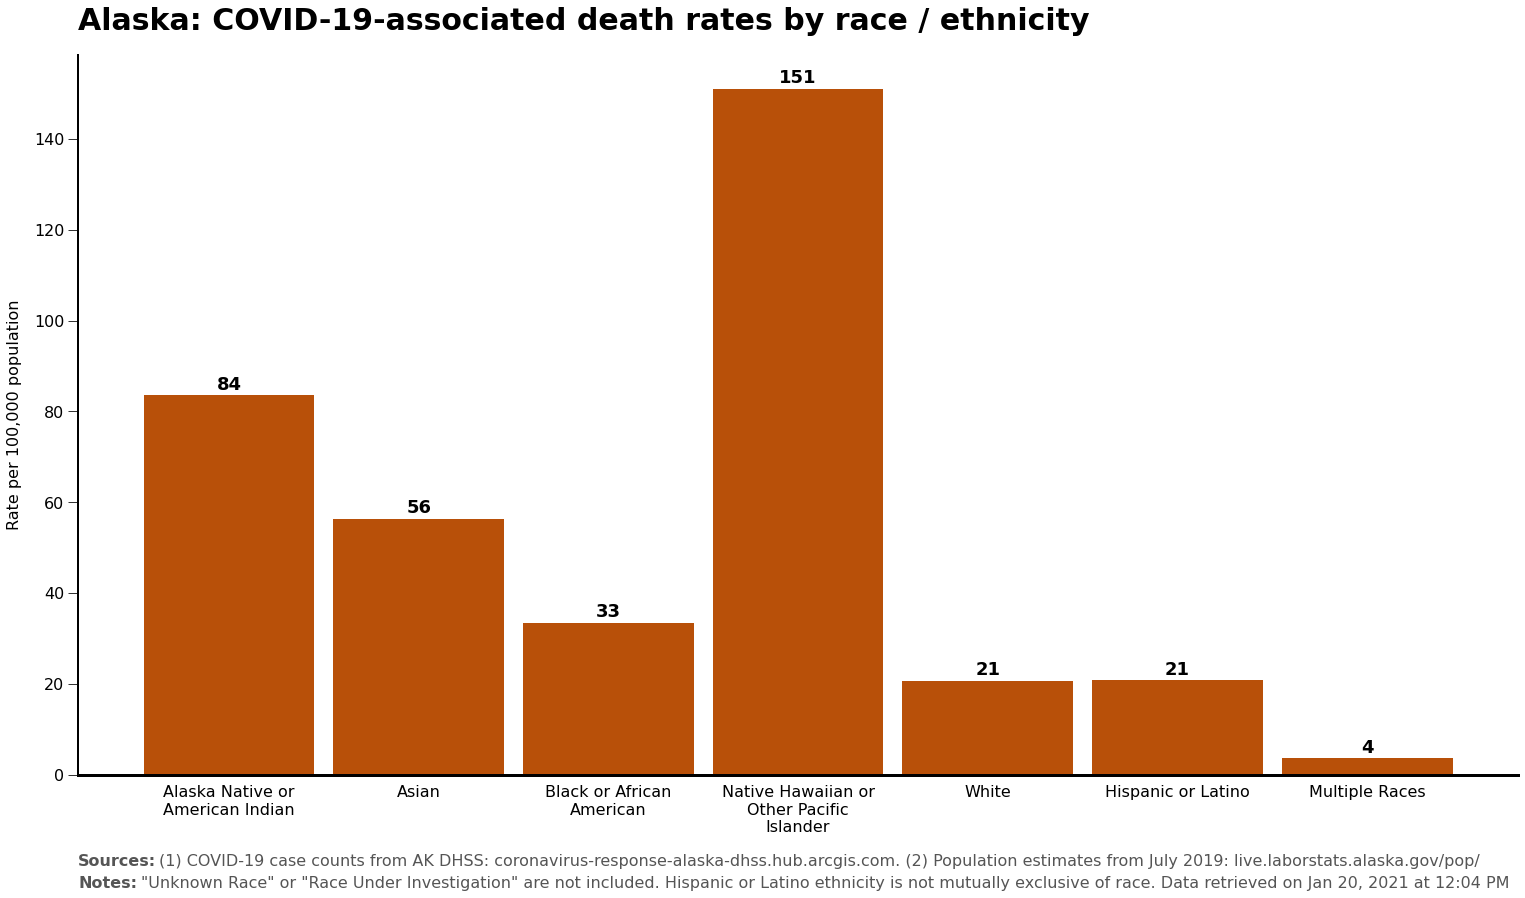

In [76]:
to_plot = rate_data.drop(labels=['Unknown Race', 'Race Under Investigation'])

case_rate_plot = rate_plot(to_plot['Case Rate'], title='Alaska: COVID-19-associated case rates by race / ethnicity')
hosp_rate_plot = rate_plot(to_plot['Hospitalization Rate'], title='Alaska: COVID-19-associated hospitalization rates by race / ethnicity', color='#33a02c')
deat_rate_plot = rate_plot(to_plot['Death Rate'], title='Alaska: COVID-19-associated death rates by race / ethnicity', color='#B85009')

In [77]:
save_png(case_rate_plot, f"../outputs/archived/{retrieval_date.strftime('%Y%m%d')}-case-rate-by-race.png")
save_png(hosp_rate_plot, f"../outputs/archived/{retrieval_date.strftime('%Y%m%d')}-hospitalization-rate-by-race.png")
save_png(deat_rate_plot, f"../outputs/archived/{retrieval_date.strftime('%Y%m%d')}-death-rate-by-race.png")

Saving PNG ../outputs/archived/20210120-case-rate-by-race.png
Saving PNG ../outputs/archived/20210120-hospitalization-rate-by-race.png
Saving PNG ../outputs/archived/20210120-death-rate-by-race.png


# Write currents out for Github README.md

In [78]:
save_png(case_count_plot, f"../outputs/latest-case-count-by-race.png")
save_png(hosp_count_plot, f"../outputs/latest-hospitalization-count-by-race.png")
save_png(deat_count_plot, f"../outputs/latest-death-count-by-race.png")
save_png(case_rate_plot, f"../outputs/latest-case-rate-by-race.png")
save_png(hosp_rate_plot, f"../outputs/latest-hospitalization-rate-by-race.png")
save_png(deat_rate_plot, f"../outputs/latest-death-rate-by-race.png")

Saving PNG ../outputs/latest-case-count-by-race.png
Saving PNG ../outputs/latest-hospitalization-count-by-race.png
Saving PNG ../outputs/latest-death-count-by-race.png
Saving PNG ../outputs/latest-case-rate-by-race.png
Saving PNG ../outputs/latest-hospitalization-rate-by-race.png
Saving PNG ../outputs/latest-death-rate-by-race.png
